# Predicting Workload

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 40, 60)            7680      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40, 40)            12960     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 20)                4080      
 onal)                                                           
                                                                 
 batch_normalization (Batch  (None, 20)                80        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 10)                2

c:\Users\brand\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


259/259 [==============================] - ETA: 0s - loss: 0.1039
Epoch 2: val_loss improved from 0.24311 to 0.07850, saving model to best_model.hdf5
259/259 [==============================] - 32s 123ms/step - loss: 0.1039 - val_loss: 0.0785 - lr: 0.0010
Epoch 3/20
259/259 [==============================] - ETA: 0s - loss: 0.0360
Epoch 3: val_loss improved from 0.07850 to 0.02750, saving model to best_model.hdf5
259/259 [==============================] - 30s 118ms/step - loss: 0.0360 - val_loss: 0.0275 - lr: 0.0010
Epoch 4/20
259/259 [==============================] - ETA: 0s - loss: 0.0207
Epoch 4: val_loss improved from 0.02750 to 0.01404, saving model to best_model.hdf5
259/259 [==============================] - 37s 143ms/step - loss: 0.0207 - val_loss: 0.0140 - lr: 0.0010
Epoch 5/20
259/259 [==============================] - ETA: 0s - loss: 0.0160
Epoch 5: val_loss improved from 0.01404 to 0.01043, saving model to best_model.hdf5
259/259 [==============================] - 45s 173ms

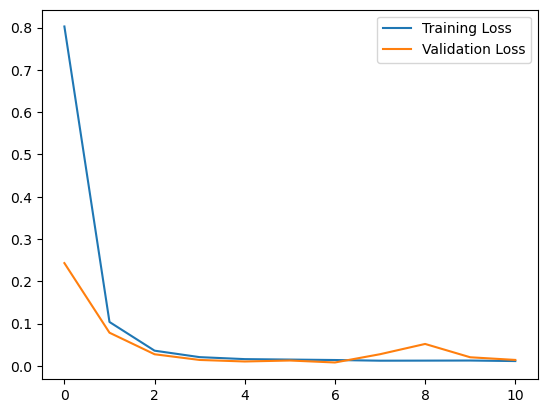

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import l2
from tensorflow import keras
from sklearn.metrics import mean_squared_error

def prepare_data(seq,num):
  x=[]
  y=[]
  for i in range(0,(len(seq)-num),1):
    
    input_ = seq[i:i+num]
    output  = seq[i+num]
    
    x.append(input_)
    y.append(output)
    
  return np.array(x), np.array(y)

data=pd.read_csv('../Utilities\csv\metrics_2024-09-11-16-52-02/1_metrics.csv')
cpu_usage = data['value'].values

# Number of samples per window (4 sequences is 1 minute)
num = 40
sample = cpu_usage[:num]

x,y= prepare_data(cpu_usage,num)

ind = int(0.7 * len(x))
x_tr = x[:ind]
y_tr = y[:ind]
x_val=x[ind:]
y_val=y[ind:]

#normalize the inputs
x_scaler= MinMaxScaler(feature_range=(0, 1))
x_tr = x_scaler.fit_transform(x_tr)
x_val= x_scaler.transform(x_val)

#reshaping the output for normalization
y_tr=y_tr.reshape(len(y_tr),1)
y_val=y_val.reshape(len(y_val),1)

#normalize the output
y_scaler=MinMaxScaler(feature_range=(0, 1))
y_tr = y_scaler.fit_transform(y_tr)[:,0]
y_val = y_scaler.transform(y_val)[:,0]

#reshaping input data
x_tr= x_tr.reshape(x_tr.shape[0],x_tr.shape[1],1)
x_val= x_val.reshape(x_val.shape[0],x_val.shape[1],1)

def traffic_prediction_lstm():
    model = Sequential()
    model.add(Bidirectional(LSTM(30, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), input_shape=(num, 1)))
    model.add(Bidirectional(LSTM(20, return_sequences=True, kernel_regularizer=l2(0.01))))
    model.add(Bidirectional(LSTM(10, return_sequences=False, kernel_regularizer=l2(0.01))))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    # Learning Rate Scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    # Print model summary
    model.summary()
    return model, lr_scheduler

lstm_model, lr_scheduler = traffic_prediction_lstm()
# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Fit the model
history = lstm_model.fit(x_tr, y_tr,
                          epochs=20,
                          batch_size=10,
                          validation_data=(x_val, y_val),
                          callbacks=[early_stopping, lr_scheduler, model_checkpoint])

lstm_model.load_weights('best_model.hdf5')

mse = lstm_model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

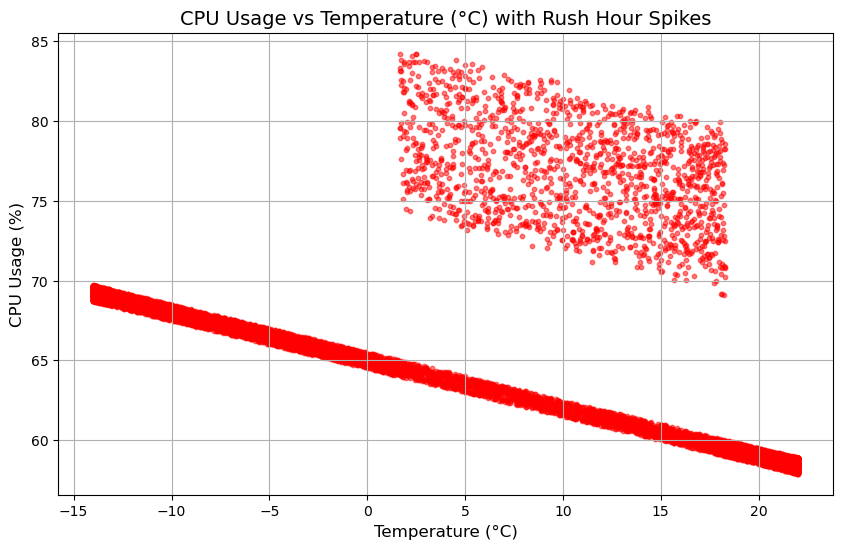

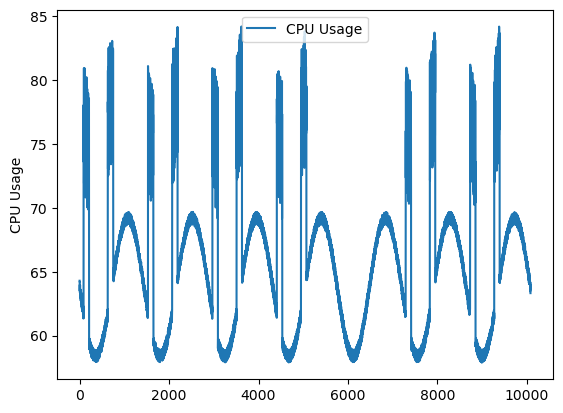

In [41]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Initialize parameters for the dataset
start_time = datetime(2024, 9, 18, 6, 0)  # Start at 6:00 AM on Sept 18, 2024
end_time = start_time + timedelta(days=7)  # 1 week of data

# Time range: 1-minute intervals for a whole week
timestamps = pd.date_range(start=start_time, end=end_time, freq='T')

# Temperature will follow a sinusoidal pattern over the day, with daily variation
def temperature_pattern(minute, max_temp=22, min_temp=4):
    # Approximate day length: 1440 minutes, so we use sin for a daily cycle
    return (max_temp - min_temp) * np.sin(2 * np.pi * (minute % 1440) / 1440) + min_temp

# Generate temperature values for each timestamp
temperatures = [temperature_pattern(i) for i in range(len(timestamps))]

# Generate CPU usage based on the inverse relationship with temperature
cpu_usage = [round(65 - 0.3 * temp + np.random.uniform(-0.5, 0.5), 2) for temp in temperatures]

# Generate random but plausible humidity (inverse of temperature)
humidity = [round(80 - 0.5 * (temp - 14) + np.random.uniform(-2, 2), 1) for temp in temperatures]

# Generate random wind speeds, increasing slightly during the day
wind_speed = [round(7 + 0.05 * np.sin(2 * np.pi * (i % 1440) / 1440) * 10 + np.random.uniform(-1, 1), 1)
              for i in range(len(timestamps))]

# Create a DataFrame
data = pd.DataFrame({
    'Timestamp': timestamps,
    'CPU Usage (%)': cpu_usage,
    'Temperature (°C)': temperatures,
    'Humidity (%)': humidity,
    'Wind Speed (km/h)': wind_speed
})

# Display the first few rows
data.head()

# Define rush hour periods: 7:30-9:30am and 4:30-6:30pm each day
rush_hour_morning_start = '07:30:00'
rush_hour_morning_end = '09:30:00'
rush_hour_evening_start = '16:30:00'
rush_hour_evening_end = '18:30:00'

# Function to add spikes in CPU usage during rush hours on weekdays
def add_rush_hour_spikes(df):
    for i, row in df.iterrows():
        time = row['Timestamp'].time()
        date_format = '%Y-%m-%d %H:%M:%S'
        date_obj = datetime.strptime(str(row['Timestamp']), date_format)
        if (date_obj.weekday() <= 5 and ((rush_hour_morning_start <= time.strftime('%H:%M:%S') <= rush_hour_morning_end) or \
           (rush_hour_evening_start <= time.strftime('%H:%M:%S') <= rush_hour_evening_end))):
            # Add a spike in CPU usage, random boost between 5-15% during rush hours
            df.at[i, 'CPU Usage (%)'] = round(row['CPU Usage (%)'] + np.random.uniform(10, 20), 2)
    return df

# Apply the rush hour spikes to the dataset
data_with_spikes = add_rush_hour_spikes(data)

# Plot the CPU Usage against Temperature again, with rush hour spikes
# plt.figure(figsize=(10, 6))
# plt.scatter(data_with_spikes['Temperature (°C)'], data_with_spikes['CPU Usage (%)'], alpha=0.5, color='r', s=10)
# plt.title('CPU Usage vs Temperature (°C) with Rush Hour Spikes', fontsize=14)
# plt.xlabel('Temperature (°C)', fontsize=12)
# plt.ylabel('CPU Usage (%)', fontsize=12)
# plt.grid(True)
# plt.show()

plt.plot(data_with_spikes['CPU Usage (%)'], label='CPU Usage')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()


1/1 [==============================] - 0s 59ms/step
Mean Squared Error: 40.8427247468412
True: [19.17190891] Predicted: [23.14136] Difference: [-3.96945042]

True: [19.17190891] Predicted: [21.792408] Difference: [-2.62049908]

True: [20.90612115] Predicted: [21.59786] Difference: [-0.69173918]

True: [20.49995935] Predicted: [21.5708] Difference: [-1.07084143]

True: [18.76345922] Predicted: [21.695784] Difference: [-2.93232439]

True: [20.26711319] Predicted: [21.920183] Difference: [-1.65306999]

True: [22.25295565] Predicted: [22.210611] Difference: [0.0423443]

True: [22.44925007] Predicted: [22.544516] Difference: [-0.09526554]

True: [22.926444] Predicted: [22.917871] Difference: [0.00857253]

True: [25.4348005] Predicted: [23.307999] Difference: [2.12680184]

True: [27.3979966] Predicted: [23.716475] Difference: [3.68152206]

True: [27.3979966] Predicted: [24.13492] Difference: [3.26307648]

True: [31.19454496] Predicted: [24.556072] Difference: [6.63847272]

True: [31.19454496

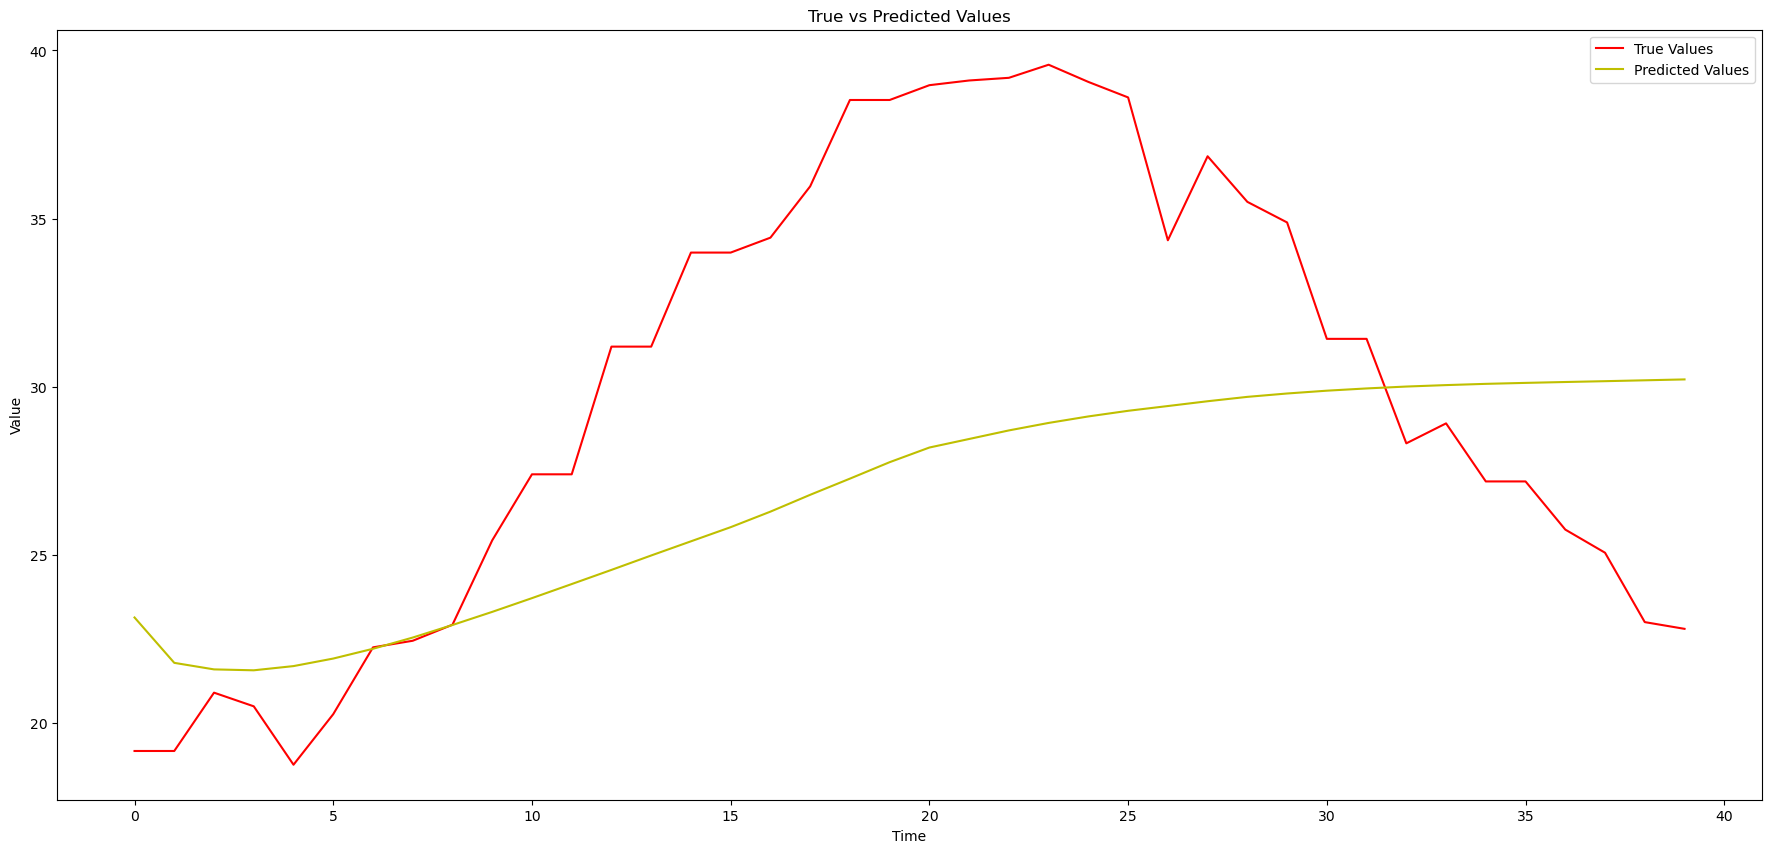

In [28]:
def forecast(x_val, no_of_pred, ind):
    predictions = []
    temp = x_val[ind].copy()  # Ensure we do not modify the original data

    for _ in range(no_of_pred):
        temp = temp.reshape(1, -1, 1)  # Ensure correct shape for prediction
        pred = lstm_model.predict(temp)[0][0]
        predictions.append(pred)
        
        # Update temp with the new prediction
        temp = np.roll(temp, -1)  # Roll the array to the left
        temp[-1, 0, 0] = pred  # Insert the prediction at the end
    return np.array(predictions)

# Number of predictions in 15s intervals (10 mins)
no_of_pred = 40
# number hours of data to predict from
ind = int(3 * 240)
y_pred= forecast(x_val,no_of_pred,ind).reshape(-1, 1)
y_true = y_val[ind:ind+(no_of_pred)].reshape(-1, 1)

# Lets convert back the normalized values to the original dimensional space
y_true= y_scaler.inverse_transform(y_true)
y_pred= y_scaler.inverse_transform(y_pred)

mse = mean_squared_error(y_true, y_pred)
print("Mean Squared Error:", mse)

# Confirming difference between true and predicted values
for x in range(len(y_true)):
    diff = y_true[x] - y_pred[x]
    print("True: " + str(y_true[x]) + " Predicted: " + str(y_pred[x]) + " Difference: " + str(diff) + "\n")

def plot(y_true, y_pred):
    ar = np.arange(len(y_true))
    plt.figure(figsize=(22, 10))
    plt.plot(ar, y_true, 'r', label='True Values')
    plt.plot(ar, y_pred, 'y', label='Predicted Values')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('True vs Predicted Values')
    plt.show()
plot(y_true,y_pred)

# Predicting number of replicas

1/1 [==============================] - 0s 30ms/step
Predicted CPU Percentage:  1.844380

Actual CPU Percentage:  27.491472

Predicted Replicas:  1

Actual Replicas:  2.000000



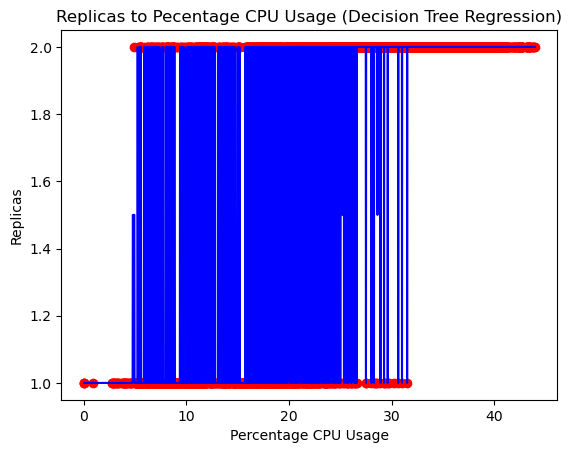

In [15]:
from sklearn.tree import DecisionTreeRegressor

dtr_cpu_usage = pd.read_csv('../Utilities\csv\metrics_2024-09-11-16-52-02/1_metrics.csv')
dtr_replicas = pd.read_csv('../Utilities\csv\metrics_2024-09-11-16-52-02/2_metrics.csv')
dtr_data = pd.merge(dtr_cpu_usage, dtr_replicas, on='timestamp')
dtr_data.rename(columns={'value_x': 'cpu_usage', 'value_y': 'replicas'}, inplace=True)
dtr_data_arr = np.array(dtr_data)

dtr_arr_cpu = dtr_data_arr[:, 1:2]
dtr_arr_replicas = dtr_data_arr[:, 2:3]

regressor = DecisionTreeRegressor(random_state = 0)

regressor.fit(dtr_arr_cpu, dtr_arr_replicas)

# Make a CPU usage prediction
# forecast(<data to predict from>, <number of predictions>, <size of data to predict from>)
num_of_preds = 40
data_to_pred_from = 720
real_prediction = forecast(dtr_cpu_usage['value'],num_of_preds,data_to_pred_from).reshape(-1, 1)

transformed_pred = y_scaler.inverse_transform(real_prediction)

# predicting a new value  
y_pred_replicas = regressor.predict([transformed_pred[-1]])

# Print predicted CPU percentage
print("Predicted CPU Percentage: % f\n"% transformed_pred[-1])
print("Actual CPU Percentage: % f\n"% dtr_cpu_usage['value'][(num_of_preds+data_to_pred_from)])
# print the predicted replicas
print("Predicted Replicas: % d\n"% y_pred_replicas)
print("Actual Replicas: % f\n"% dtr_replicas['value'][(num_of_preds+data_to_pred_from)])

# arange for creating a range of values 
# from min value of X to max value of X 
# with a difference of 0.01 between two 
# consecutive values 
X_grid = np.arange(min(dtr_arr_cpu), max(dtr_arr_cpu), 0.01) 

# reshape for reshaping the data into 
# a len(X_grid)*1 array, i.e. to make 
# a column out of the X_grid values 
X_grid = X_grid.reshape((len(X_grid), 1)) 

# scatter plot for original data 
plt.scatter(dtr_arr_cpu, dtr_arr_replicas, color = 'red') 

# plot predicted data 
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue') 

# specify title 
plt.title('Replicas to Pecentage CPU Usage (Decision Tree Regression)') 

# specify X axis label 
plt.xlabel('Percentage CPU Usage') 

# specify Y axis label 
plt.ylabel('Replicas') 

# show the plot 
plt.show() 

